In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler

In [ ]:
moa = pd.read_excel('.../mall_of_america.xlsx')
moa.head()

,device,session_date,apple_flag,entry_time,exit_time,duration,total_updates,weekend_flag,day_of_week,time_northfoodcourt,...,time_3_NW,time_3_S,time_3_SE,time_3_SW,time_3_W,session_updates_0_1,session_updates_0,employee_flag,theatre_flag,park_flag
0,device:00:c6:10:ab:d8:20,2016-01-01,1,2016-01-01 12:36:29.010,2016-01-01 17:54:10.250,19061.0,35,0,6,0,...,0,0,0,0,0,0,0,0,0,0
1,device:04:4b:ed:06:ee:68,2016-01-01,1,2016-01-01 12:59:53.390,2016-01-01 16:11:50.190,11517.0,137,0,6,0,...,105,2048,0,1511,332,0,0,0,0,0
2,device:04:f1:3e:e2:ce:81,2016-01-01,1,2016-01-01 09:37:13.370,2016-01-01 20:36:14.700,39541.0,241,0,6,0,...,0,38902,0,553,86,0,0,1,0,0
3,device:08:74:02:06:bc:66,2016-01-01,1,2016-01-01 11:15:56.060,2016-01-01 18:06:46.630,24650.0,145,0,6,1254,...,0,0,0,0,0,0,0,1,0,0
4,device:0c:15:39:2d:0f:75,2016-01-01,1,2016-01-01 17:06:38.920,2016-01-01 22:50:27.310,20629.0,129,0,6,0,...,48,989,0,1228,42,0,11,0,0,0


Question 1: Filter out employees and short-duration visitors

In [ ]:
moa_filtered = moa[(moa['employee_flag'] != 1) & (moa['duration'] > 1800)]#includes all records where the employee_flag is 0 and duration of the visit is atleast 1800 seconds
len(moa_filtered) #no.of rows in the filtered dataset

4832

Question 2: K-means clusters on the levels

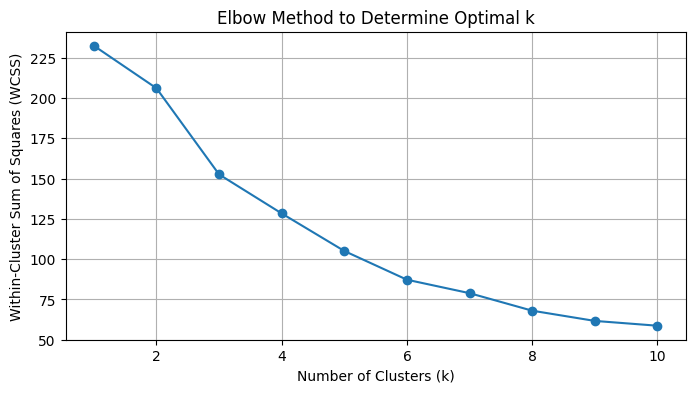

In [ ]:

time_levels = moa_filtered[['time_0', 'time_1', 'time_2', 'time_3', 'time_4']]
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_time_levels = scaler.fit_transform(time_levels[['time_0', 'time_1', 'time_2', 'time_3', 'time_4']])

#K-means to find optimal clusters
from sklearn.cluster import KMeans

WCSS = [] #Within Cluster Sum of Squared Errors
cluster_range = range(1, 11) #defining a cluster range

for num_clusters in cluster_range: #Loop over different values of clusters to find the optimal number
    kmeans = KMeans(num_clusters,random_state=42) # Initialize Kmeams with current number of clusteas
    kmeans.fit(scaled_time_levels) # Fit Kmeans to the scaled data (scaled_time_levels)
    WCSS.append(kmeans.inertia_)  # Append the Within-Cluster Sum of Squares (inertia) to the list

# Plotting the elbow curve
plt.figure(figsize=(8,4))
plt.plot(cluster_range, WCSS, marker="o")
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method to Determine Optimal k')
plt.grid(True)
plt.show()

In [ ]:
#calculating Silhouette Scores to understand the quality of clusters ranging from 2-10
cluster_range = range(2, 11) #defining a cluster range

for num_clusters in cluster_range: #Loop through a range of cluster values to evaluate clustering quality using silhouette score
    kmeans = KMeans(num_clusters,random_state=42) #Initialize Kmeams with current number of clusteas
    kmeans.fit(scaled_time_levels)
    score = silhouette_score(scaled_time_levels, kmeans.labels_)
    print(f'Silhouette Score: {score:.4f}')  #Print the silhouette score for the current number of clusters

# Choose the optimal number of clusters based on the Elbow method and Silhouette Scores
# Assuming an optimal number of clusters is chosen after evaluating the plots/scores
# For demonstration, let's assume 3 clusters are chosen as an example (you should determine this based on analysis)
optimal_clusters = 4

# Fit KMeans with the optimal number of clusters
kmeans_optimal = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans_optimal.fit(scaled_time_levels)


Silhouette Score: 0.6382
Silhouette Score: 0.4409
Silhouette Score: 0.4264
Silhouette Score: 0.4090
Silhouette Score: 0.4389
Silhouette Score: 0.3388
Silhouette Score: 0.3487
Silhouette Score: 0.3596
Silhouette Score: 0.3330


KMeans(n_clusters=4, random_state=42)

In [ ]:
# Add the cluster labels to the moa_filtered DataFrame
moa_filtered['cluster'] = kmeans_optimal.labels_

#Cluster table with average time spent on each floor
moa_filtered.groupby('cluster')[['time_0', 'time_1','time_2', 'time_3', 'time_4' ]].mean().round(2)

,time_0,time_1,time_2,time_3,time_4
cluster,,,,,
0,324.97,3894.24,6701.88,8652.98,860.12
1,461.22,2694.50,1290.90,2119.70,941.92
2,52190.93,616.93,836.03,636.24,260.32
3,203.06,17536.42,1691.07,2848.78,620.16


Question 3: Apple users' behavior across clusters

In [ ]:
# Grouping the filtered data (moa_filtered) by both 'cluster' and 'apple_flag'
# Calculating the mean of the selected time columns for each group
avg_time_by_apple = moa_filtered.groupby(['cluster', 'apple_flag'])[['time_0', 'time_1', 'time_2', 'time_3', 'time_4']].mean().round(2)
avg_time_by_apple

time_0    time_1   time_2    time_3   time_4
cluster apple_flag                                                
0       0             548.40   3414.44  6100.96  10291.25   741.90
        1             190.09   4183.90  7064.67   7663.92   931.50
1       0             597.09   2532.07  1132.51   2183.35  1102.27
        1             391.05   2778.39  1372.70   2086.82   859.11
2       0           47256.12    793.20  1022.77    804.21   334.70
        1           69462.75      0.00   182.44     48.31     0.00
3       0             490.77  17268.76  1561.75   2422.10   558.38
        1              63.11  17666.61  1753.98   3056.33   650.22

Question 4 : Identify popular sections
within high-dwell floors

In [ ]:
# define target clusters that spend more time either on level 2 or 3
target_clusters = [0, 1, 3]

# Define column names for Level 2 and Level 3 sections
level2_cols = ['time_2_E', 'time_2_N', 'time_2_NE', 'time_2_NEx', 'time_2_NW',
               'time_2_S', 'time_2_SE', 'time_2_SW', 'time_2_W']

level3_cols = ['time_3_E', 'time_3_N', 'time_3_NE', 'time_3_NEx', 'time_3_NW',
               'time_3_S', 'time_3_SE', 'time_3_SW', 'time_3_W']

# Loop through each target cluster
for cluster_id in target_clusters:
    print(f"\nCluster {cluster_id} - Top Sections in Level 2 & 3:")

    # Filter rows for this cluster (0,1,3)
    cluster_data = moa_filtered[moa_filtered['cluster'] == cluster_id]

    # Sum total time for each section across all users in this cluster
    level2_sum = cluster_data[level2_cols].sum()
    level3_sum = cluster_data[level3_cols].sum()

    # Combine Level 2 and Level 3 sums
    combined = pd.concat([level2_sum, level3_sum])

    # Sort and get top 3 sections
    top_sections = combined.sort_values(ascending=False).head(5)


    print(top_sections)


Cluster 0 - Top Sections in Level 2 & 3:
time_3_SE    1026822.0
time_3_S      929628.0
time_3_SW     727248.0
time_2_E      636344.0
time_2_W      633931.0
dtype: float64

Cluster 1 - Top Sections in Level 2 & 3:
time_3_S     1897035.0
time_3_SW    1160747.0
time_3_SE     838336.0
time_2_E      783728.0
time_3_E      749835.0
dtype: float64

Cluster 3 - Top Sections in Level 2 & 3:
time_3_S     642531.0
time_3_SE    339820.0
time_2_E     232458.0
time_3_SW    205774.0
time_2_N     161235.0
dtype: float64


Question 5 : Uncover loyalty and repeat visit behavior

In [ ]:
# Count number of unique visit days per device
visit_counts = moa_filtered.groupby('device')['session_date'].nunique().reset_index()
visit_counts.columns = ['device', 'visit_days']

# Define repeat visitors (more than 1 visit in the 30-day period)
repeat_devices = visit_counts[visit_counts['visit_days'] > 1]['device']

# Create a flag in original data
moa_filtered['is_repeat_visitor'] = moa_filtered['device'].isin(repeat_devices).astype(int)

In [ ]:
# Group by cluster and repeat flag
repeat_cluster_counts = moa_filtered.groupby(['cluster', 'is_repeat_visitor']).size().unstack(fill_value=0)

# Normalize for percentage
repeat_cluster_percent = (repeat_cluster_counts.T / repeat_cluster_counts.sum(axis=1)).T.round(2)

print("Repeat vs Non-Repeat Visitor Count by Cluster:")
print(repeat_cluster_counts)
print("\nRepeat Visitor Percentage by Cluster:")
print(repeat_cluster_percent)

Repeat vs Non-Repeat Visitor Count by Cluster:
is_repeat_visitor     0     1
cluster                      
0                   247   356
1                  1376  2124
2                     4    68
3                   270   387

Repeat Visitor Percentage by Cluster:
is_repeat_visitor     0     1
cluster                      
0                  0.41  0.59
1                  0.39  0.61
2                  0.06  0.94
3                  0.41  0.59


In [ ]:
floor_cols = ['time_0_1', 'time_0', 'time_1', 'time_2', 'time_3', 'time_4'] # Define the list of floor-level time features (overall time spent on each floor)
section_cols = [
    'time_2_E', 'time_2_N', 'time_2_NE', 'time_2_NW', 'time_2_S', 'time_2_SE', 'time_2_SW', 'time_2_W',
    'time_3_E', 'time_3_N', 'time_3_NE', 'time_3_NW', 'time_3_S', 'time_3_SE', 'time_3_SW', 'time_3_W'

] #Define the list of section-level time features (time spent in different directions of floor 2 and 3)

# Group the data by whether the visitor is a repeat visitor or not (0 = Non-repeat, 1 = Repeat)
# Then compute the average time spent in each floor and section
repeat_behavior = moa_filtered.groupby('is_repeat_visitor')[floor_cols + section_cols].mean().round(1)
repeat_behavior.index = ['Non-Repeat', 'Repeat']
repeat_behavior

,time_0_1,time_0,time_1,time_2,time_3,time_4,time_2_E,time_2_N,time_2_NE,time_2_NW,...,time_2_SW,time_2_W,time_3_E,time_3_N,time_3_NE,time_3_NW,time_3_S,time_3_SE,time_3_SW,time_3_W
Non-Repeat,4.2,206.4,5106.9,1898.3,3028.7,964.1,336.3,268.6,240.4,190.8,...,230.9,268.2,287.9,180.6,201.8,226.9,797.3,414.3,461.3,165.5
Repeat,5.9,1809.1,4653.1,2088.4,3001.3,822.0,346.8,239.5,193.8,185.5,...,308.3,322.2,279.0,199.7,216.8,203.6,667.0,483.5,416.2,209.5


In [ ]:
attraction_cols = ['park_flag', 'theatre_flag', 'time_northfoodcourt', 'time_southfoodcourt'] # Define a list of columns related to visitor engagement with specific attractions

# Average attraction engagement for repeat vs non-repeat
# Group the dataset by whether the visitor is a repeat visitor (0 = Non-Repeat, 1 = Repeat)
# Then calculate the average values for each attraction-related column
attraction_comparison = moa_filtered.groupby('is_repeat_visitor')[attraction_cols].mean().round(2)
attraction_comparison.index = ['Non-Repeat', 'Repeat']
print(attraction_comparison)


            park_flag  theatre_flag  time_northfoodcourt  time_southfoodcourt
Non-Repeat       0.27          0.03               269.30               411.14
Repeat           0.15          0.05               298.44               292.21


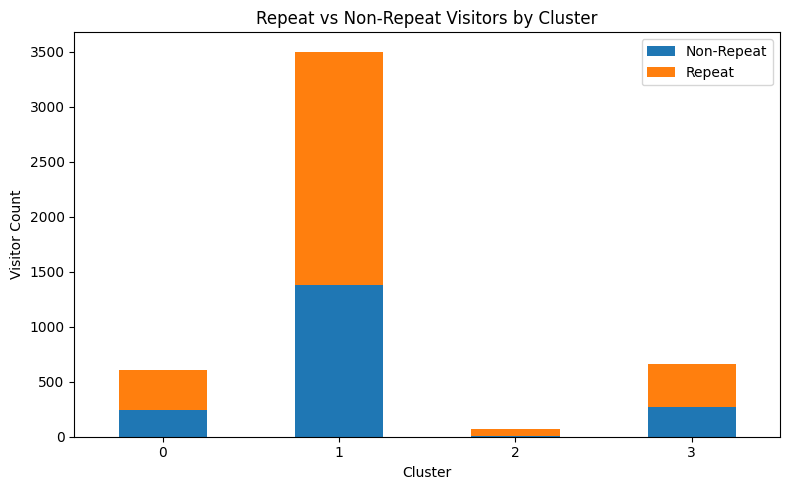

In [ ]:
# Visualization
repeat_cluster_counts.plot(kind='bar', stacked=True, figsize=(8, 5))
plt.title("Repeat vs Non-Repeat Visitors by Cluster")
plt.ylabel("Visitor Count")
plt.xlabel("Cluster")
plt.xticks(rotation=0)
plt.legend(["Non-Repeat", "Repeat"])
plt.tight_layout()
plt.show()


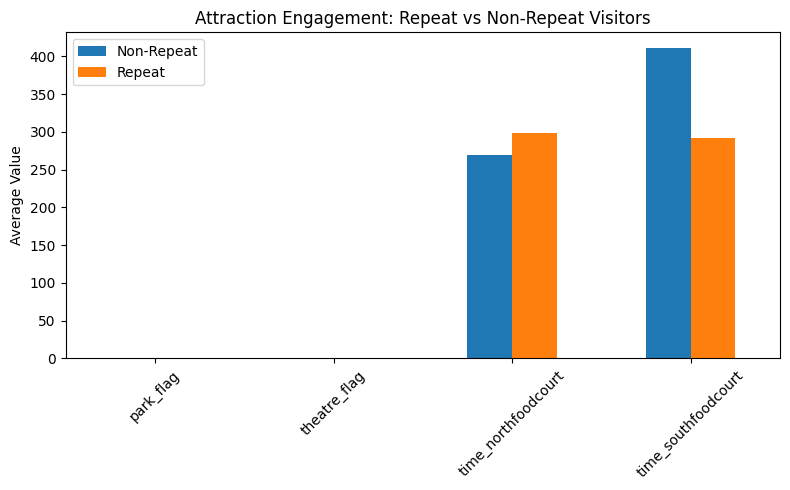

In [ ]:
# Visualization
attraction_comparison.T.plot(kind='bar', figsize=(8, 5))
plt.title("Attraction Engagement: Repeat vs Non-Repeat Visitors")
plt.ylabel("Average Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Question 6 : Analyze visitor entry times in relation to cluster membership

In [ ]:
# Ensure entry_time is datetime
moa_filtered['entry_time'] = pd.to_datetime(moa_filtered['entry_time'])

# Extract hour
moa_filtered['entry_hour'] = moa_filtered['entry_time'].dt.hour

# Assign time slot
def classify_time_of_day(hour):
    if 4 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening' # This line was missing indentation

moa_filtered['entry_slot'] = moa_filtered['entry_hour'].apply(classify_time_of_day)

In [ ]:
# Count of cluster members in each time slot
entry_cluster_dist = moa_filtered.groupby(['entry_slot', 'cluster']).size().unstack(fill_value=0)

# Normalize to percentages
entry_cluster_pct = (entry_cluster_dist.T / entry_cluster_dist.sum(axis=1)).T.round(2)

print("Visitor Count by Time Slot and Cluster:\n")
print(entry_cluster_dist)

print("\nPercentage Distribution by Time Slot:\n")
print(entry_cluster_pct)


Visitor Count by Time Slot and Cluster:

cluster       0     1   2    3
entry_slot                    
Afternoon   336  2147   7  310
Evening      20   692   0   19
Morning     247   661  65  328

Percentage Distribution by Time Slot:

cluster        0     1     2     3
entry_slot                        
Afternoon   0.12  0.77  0.00  0.11
Evening     0.03  0.95  0.00  0.03
Morning     0.19  0.51  0.05  0.25


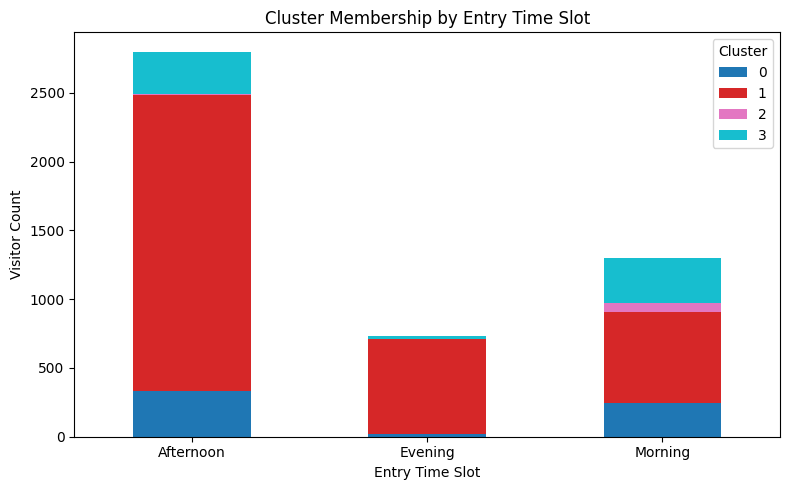

In [ ]:
# Stacked bar plot
entry_cluster_dist.plot(kind='bar', stacked=True, figsize=(8, 5), colormap='tab10')
plt.title("Cluster Membership by Entry Time Slot")
plt.xlabel("Entry Time Slot")
plt.ylabel("Visitor Count")
plt.xticks(rotation=0)
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

Question 7 : Compare weekend vs. weekday visitor behavior

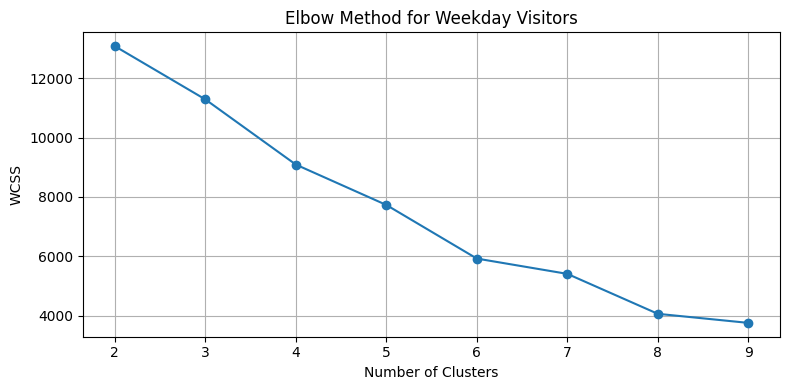

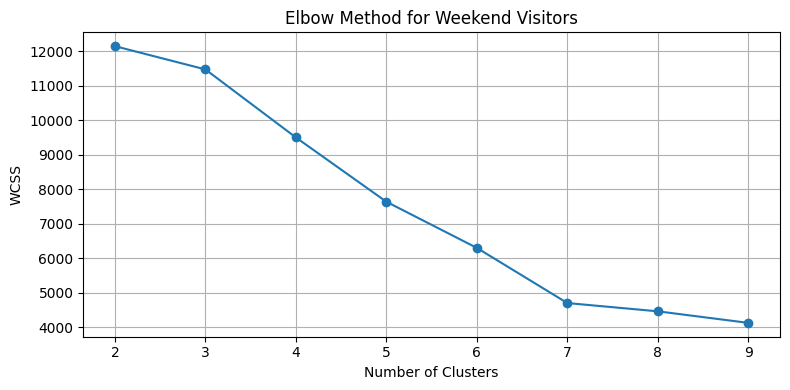

In [ ]:
# Create 'weekday_flag': 1 for weekend (Saturday=5, Sunday=6), 0 for weekday
moa_filtered['weekday_flag'] = moa_filtered['session_date'].dt.dayofweek.apply(lambda x: 1 if x >= 5 else 0)
# Split into weekday and weekend datasets
weekday_df = moa_filtered[moa_filtered['weekday_flag'] == 0].copy()
weekend_df = moa_filtered[moa_filtered['weekday_flag'] == 1].copy()

# Import StandardScaler here
from sklearn.preprocessing import StandardScaler

def elbow_cluster_analysis(df, label):
    X = df[floor_cols].fillna(0)
    X_scaled = StandardScaler().fit_transform(X)

    # Elbow method to find optimal k
    wcss = []
    for k in range(2, 10):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(X_scaled)
        wcss.append(kmeans.inertia_)

    # Plot elbow curve
    plt.figure(figsize=(8, 4))
    plt.plot(range(2, 10), wcss, marker='o')
    plt.title(f'Elbow Method for {label} Visitors')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function to perform analysis and plot for both dataframes
elbow_cluster_analysis(weekday_df, 'Weekday')
elbow_cluster_analysis(weekend_df, 'Weekend')

In [ ]:
def final_kmeans_clusters(df, label, k): # Define a function to apply KMeans clustering and return both the updated dataframe and cluster profiles
    X = df[floor_cols].fillna(0) #Select the floor-related columns and fill any missing values with 0
    X_scaled = StandardScaler().fit_transform(X) #Standardize the features to ensure equal weight (mean=0, std=1)
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto') #Apply KMeans clustering with k clusters
    df[label + '_cluster'] = kmeans.fit_predict(X_scaled) #Assign cluster labels back to the original dataframe
    return df, df.groupby(label + '_cluster')[floor_cols].mean().round(1) #Return the modified dataframe and the average profile of each cluster

# Run the clustering function on weekday and weekend datasets separately
weekday_df, weekday_cluster_profiles = final_kmeans_clusters(weekday_df, 'weekday', 3)
weekend_df, weekend_cluster_profiles = final_kmeans_clusters(weekend_df, 'weekend', 4)
print("Weekday Cluster Profiles:")
print(weekday_cluster_profiles)

print("\nWeekend Cluster Profiles:")
print(weekend_cluster_profiles)


Weekday Cluster Profiles:
                 time_0_1  time_0   time_1  time_2  time_3   time_4
weekday_cluster                                                    
0                     5.6  1953.9   2549.8  1924.6  3020.9    203.6
1                     0.0   212.5  18420.3  2312.6  2723.5    279.1
2                     0.0   837.4   1760.0   873.5  1897.4  11013.8

Weekend Cluster Profiles:
                 time_0_1  time_0  time_1  time_2  time_3  time_4
weekend_cluster                                                  
0                     9.8   127.7  7223.0  1899.9  9445.9   666.9
1                     0.0   156.3  5821.9  9167.9  2346.4   951.7
2                     0.6   828.0  4876.7  1140.5  1768.9  1059.7
3                  8775.0     0.0     0.0     0.0   902.0     0.0


Question 8 : Do customers spend more or less time in the mall depending on the day of the week? Identify which days see longer average visit durations. On that specific day, which floor is crowded?

In [ ]:
# Average duration by day_of_week (1 = Sunday, ..., 7 = Saturday)
avg_duration_by_day = moa_filtered.groupby('day_of_week')['duration'].mean().round(1).sort_values(ascending=False)

# Print results
print("Average Visit Duration by Day of Week:")
print(avg_duration_by_day)

# Also calculate average floor-wise time on the busiest day
busiest_day = avg_duration_by_day.idxmax()
busiest_day_df = moa_filtered[moa_filtered['day_of_week'] == busiest_day]

# Floor time columns
floor_cols = ['time_0_1', 'time_0', 'time_1', 'time_2', 'time_3', 'time_4']
avg_floor_time = busiest_day_df[floor_cols].mean().round(1).sort_values(ascending=False)

# Print most crowded floors
print(f"\nAverage Time Spent on Each Floor on Day {busiest_day} (Busiest Day):")
print(avg_floor_time)

Average Visit Duration by Day of Week:
day_of_week
7    12763.4
4    12639.4
3    12368.2
2    11687.9
1    11306.3
6    11226.9
5    11223.8
Name: duration, dtype: float64

Average Time Spent on Each Floor on Day 7 (Busiest Day):
time_1      5630.5
time_3      3191.4
time_2      2257.8
time_4      1043.2
time_0       596.5
time_0_1       8.7
dtype: float64
